In [3]:
!pip install pytorch-lightning wandb

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 2.6 MB/s eta 0:00:002.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 445.5 kB/s eta 0:00:000:00:01m eta 0:00:01

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os, sys
from argparse import Namespace
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

plt.style.use('tableau-colorblind10')

In [5]:
print('Python version:', sys.version)
print('Package versions:')
print('Pytorch:', torch.__version__)
print('Pytorch-Lightning:', pl.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
print('Weights&Biases:', wandb.__version__)

Python version: 3.12.5 (main, Aug  9 2024, 08:20:41) [GCC 14.2.1 20240805]
Package versions:
Pytorch: 2.4.1+cu121
Pytorch-Lightning: 2.4.0
Matplotlib: 3.9.0
scikit-learn: 1.5.0
Weights&Biases: 0.17.9


In [7]:
for dirname, _, filenames in os.walk('../../data/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/kaggle/README.md
../../data/kaggle/artificialNoAnomaly/artificialNoAnomaly/art_daily_no_noise.csv
../../data/kaggle/artificialNoAnomaly/artificialNoAnomaly/art_daily_perfect_square_wave.csv
../../data/kaggle/artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv
../../data/kaggle/artificialNoAnomaly/artificialNoAnomaly/art_flatline.csv
../../data/kaggle/artificialNoAnomaly/artificialNoAnomaly/art_noisy.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_daily_flatmiddle.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsdown.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_daily_nojump.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_increase_spike_density.csv
../../data/kaggle/artificialWithAnomaly/artificialWithAnomaly/art_load_balancer_spikes.csv
../../data/kaggle/realAWSCloudwatch/realAWSC

In [8]:
datafile_path = Path('../../data/kaggle/realKnownCause/realKnownCause/machine_temperature_system_failure.csv')
datasets_root = Path('../../data/kaggle/working')

In [9]:
raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [10]:
raw_dt.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


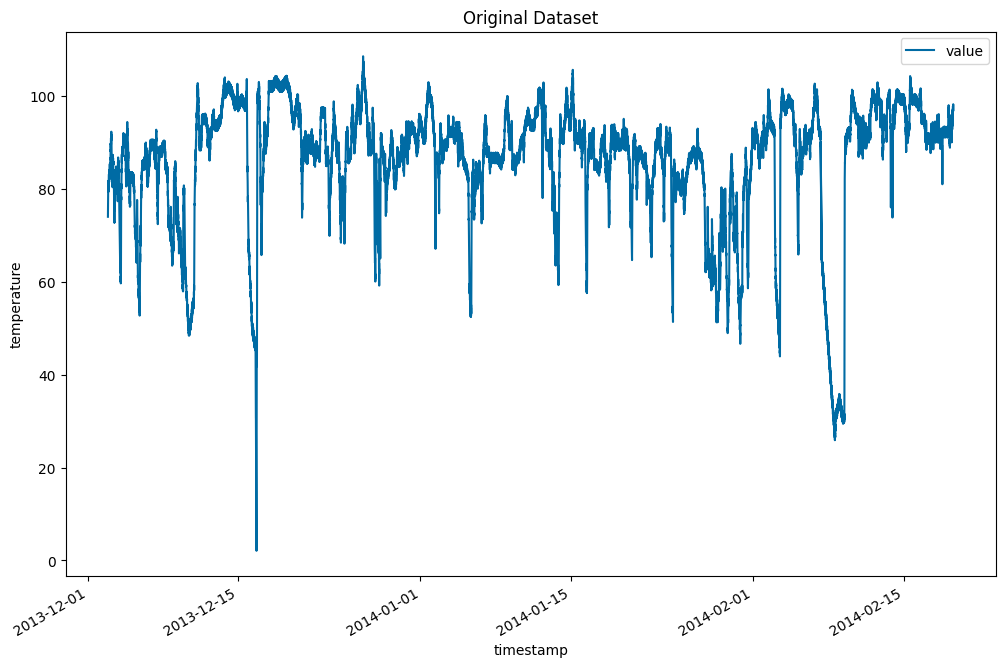

In [11]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset");

In [12]:
data['timestamp'].min(), data['timestamp'].max()

(Timestamp('2013-12-02 21:15:00'), Timestamp('2014-02-19 15:25:00'))

In [24]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

In [19]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [21]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [27]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [30]:
data['gap_holiday'] = data['gap_holiday'].astype('timedelta64[D]')

ValueError: Cannot convert from timedelta64[us] to timedelta64[D]. Supported resolutions are 's', 'ms', 'us', 'ns'

In [31]:
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

In [32]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,2,12,21.250000,0,0,-23 days,13860189
1,74.935882,2,12,21.333333,0,0,-23 days,13860192
2,76.124162,2,12,21.416667,0,0,-23 days,13860195
3,78.140707,2,12,21.500000,0,0,-23 days,13860198
4,79.329836,2,12,21.583333,0,0,-23 days,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,19,2,15.083333,2,0,49 days,13928223
22691,97.804168,19,2,15.166667,2,0,49 days,13928226
22692,97.135468,19,2,15.250000,2,0,49 days,13928229
22693,98.056852,19,2,15.333333,2,0,49 days,13928232


In [33]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,-23 days,13860189
1,74.935882,1,2,21.333333,0,0,-23 days,13860192
2,76.124162,1,2,21.416667,0,0,-23 days,13860195
3,78.140707,1,2,21.500000,0,0,-23 days,13860198
4,79.329836,1,2,21.583333,0,0,-23 days,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,49 days,13928223
22691,97.804168,18,1,15.166667,2,0,49 days,13928226
22692,97.135468,18,1,15.250000,2,0,49 days,13928229
22693,98.056852,18,1,15.333333,2,0,49 days,13928232


In [35]:
test_ratio = 0.3

In [36]:
# tr_data = data.iloc[tr_idx]
# tst_data = data.iloc[tst_idx]
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [38]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

DTypePromotionError: The DType <class 'numpy.dtypes.Float64DType'> could not be promoted by <class 'numpy.dtypes.TimeDelta64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Int64DType'>)

In [39]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

NameError: name 'scaler' is not defined